In [56]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from difflogic import LogicLayer
import matplotlib.pyplot as plt

In [65]:
BATCH_SIZE = 128
GATE_OPTIMIZER = 'softmax'
GUMBEL_TAU = 1
LATENT_DIM = 128
EPOCHS = 1000
NETWORK_LR = 0.01
CONNECTIONS= 'learned'
NOISE_TEMP= 0.4

In [66]:
device = torch.device('cuda')

transform = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.MNIST(root='../data', train=True, download=True, transform=transform)
test_ds = datasets.MNIST(root='../data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [67]:
class DiffLogicAutoencoder(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            LogicLayer(784, 392, device='cuda', implementation='cuda',
                      gate_function=GATE_OPTIMIZER, gumbel_tau=GUMBEL_TAU,noise_temp=NOISE_TEMP),
            LogicLayer(392, 196, device='cuda', implementation='cuda',
                      gate_function=GATE_OPTIMIZER, gumbel_tau=GUMBEL_TAU,noise_temp=NOISE_TEMP),
        )
        self.decoder = nn.Sequential(
            LogicLayer(196, 392, device='cuda', implementation='cuda',
                      gate_function=GATE_OPTIMIZER, gumbel_tau=GUMBEL_TAU,connections=CONNECTIONS,noise_temp=NOISE_TEMP),
            LogicLayer(392, 784, device='cuda', implementation='cuda',
                      gate_function=GATE_OPTIMIZER, gumbel_tau=GUMBEL_TAU,connections=CONNECTIONS,noise_temp=NOISE_TEMP),
        )
    
    def forward(self, x):
        latent = self.encoder(x)
        recon = self.decoder(latent)
        return recon, latent

model = DiffLogicAutoencoder(LATENT_DIM).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=NETWORK_LR)


In [ ]:
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        x_flat = x.view(x.size(0), -1)
        
        recon, latent = model(x)
        loss = criterion(recon, x_flat)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}: loss={avg_loss:.4f}')


Epoch 1: loss=0.7365
Epoch 2: loss=0.6947
Epoch 3: loss=0.6936
Epoch 4: loss=0.6933
Epoch 5: loss=0.6928
Epoch 6: loss=0.6926
Epoch 7: loss=0.6926
Epoch 8: loss=0.6925
Epoch 9: loss=0.6925
Epoch 10: loss=0.6923
Epoch 11: loss=0.6922
Epoch 12: loss=0.6922
Epoch 13: loss=0.6921
Epoch 14: loss=0.6921
Epoch 15: loss=0.6921
Epoch 16: loss=0.6920
Epoch 17: loss=0.6920
Epoch 18: loss=0.6920
Epoch 19: loss=0.6920
Epoch 20: loss=0.6920
Epoch 21: loss=0.6920
Epoch 22: loss=0.6920
Epoch 23: loss=0.6920
Epoch 24: loss=0.6920
Epoch 25: loss=0.6920
Epoch 26: loss=0.6920
Epoch 27: loss=0.6920
Epoch 28: loss=0.6920
Epoch 29: loss=0.6920
Epoch 30: loss=0.6920
Epoch 31: loss=0.6920
Epoch 32: loss=0.6920
Epoch 33: loss=0.6920
Epoch 34: loss=0.6920
Epoch 35: loss=0.6920
Epoch 36: loss=0.6920
Epoch 37: loss=0.6920
Epoch 38: loss=0.6920
Epoch 39: loss=0.6920
Epoch 40: loss=0.6920
Epoch 41: loss=0.6920
Epoch 42: loss=0.6920
Epoch 43: loss=0.6920
Epoch 44: loss=0.6920
Epoch 45: loss=0.6920
Epoch 46: loss=0.69

In [ ]:
@torch.no_grad()
def test_reconstruction(model, test_loader, n_samples=8):
    model.train()
    x, _ = next(iter(test_loader))
    x = x[:n_samples].to(device)
    x_flat = x.view(x.size(0), -1)
    
    recon, _ = model(x)
    recon_imgs = torch.sigmoid(recon).view(-1, 28, 28).cpu()
    orig_imgs = x.view(-1, 28, 28).cpu()
    
    fig, axes = plt.subplots(2, n_samples, figsize=(12, 3))
    for i in range(n_samples):
        axes[0, i].imshow(orig_imgs[i], cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(recon_imgs[i], cmap='gray')
        axes[1, i].axis('off')
    axes[0, 0].set_ylabel('Original', size=12)
    axes[1, 0].set_ylabel('Reconstructed', size=12)
    plt.tight_layout()
    print('Saved reconstruction to ae_recon.png')

@torch.no_grad()
def test_discrete(model, test_loader, n_samples=8):
    model.eval()
    
    x, _ = next(iter(test_loader))
    x = x[:n_samples].to(device)
    x_flat = x.view(x.size(0), -1)
    
    recon, _ = model(x)
    recon_imgs = torch.sigmoid(recon).view(-1, 28, 28).cpu()
    orig_imgs = x.view(-1, 28, 28).cpu()
    
    fig, axes = plt.subplots(2, n_samples, figsize=(12, 3))
    for i in range(n_samples):
        axes[0, i].imshow(orig_imgs[i], cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(recon_imgs[i], cmap='gray')
        axes[1, i].axis('off')
    axes[0, 0].set_ylabel('Original', size=12)
    axes[1, 0].set_ylabel('Eval Mode', size=12)
    plt.tight_layout()
    print('Saved eval reconstruction to ae_eval.png')



Saved reconstruction to ae_recon.png
Saved eval reconstruction to ae_eval.png


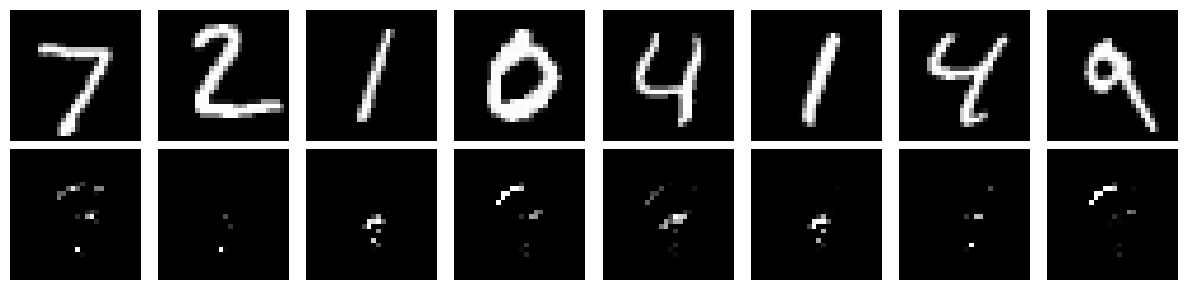

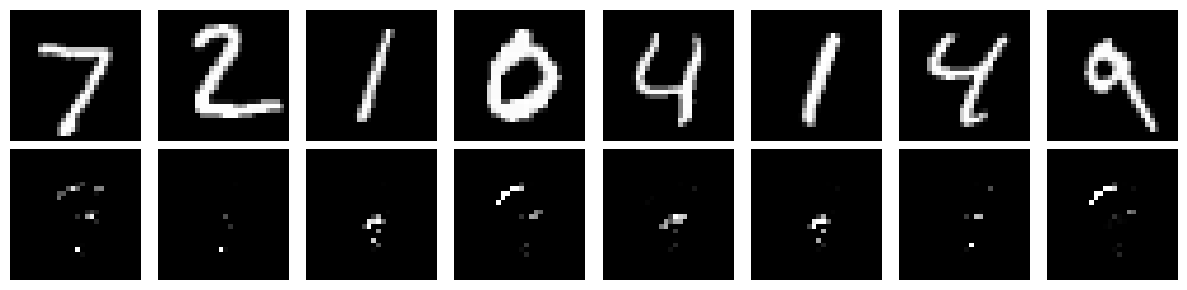

In [63]:
test_reconstruction(model, test_loader)
test_discrete(model, test_loader)

In [ ]:
sparsemax_noise = 0.4

Epoch 1: loss=0.7243
Epoch 2: loss=0.6937
Epoch 3: loss=0.6932
Epoch 4: loss=0.6930
Epoch 5: loss=0.6930
Epoch 6: loss=0.6929
Epoch 7: loss=0.6928
Epoch 8: loss=0.6926
Epoch 9: loss=0.6925
Epoch 10: loss=0.6925
Epoch 11: loss=0.6924
Epoch 12: loss=0.6924
Epoch 13: loss=0.6924
Epoch 14: loss=0.6924
Epoch 15: loss=0.6923
Epoch 16: loss=0.6922
Epoch 17: loss=0.6922
Epoch 18: loss=0.6922
Epoch 19: loss=0.6920
Epoch 20: loss=0.6920
Epoch 21: loss=0.6920
Epoch 22: loss=0.6920
Epoch 23: loss=0.6920
Epoch 24: loss=0.6919
Epoch 25: loss=0.6918
Epoch 26: loss=0.6918
Epoch 27: loss=0.6918
Epoch 28: loss=0.6918
Epoch 29: loss=0.6918
Epoch 30: loss=0.6918

SyntaxError: invalid syntax (1515654120.py, line 1)